In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
import sys

In [2]:
drive.mount("/content/drive")
sys.path.insert(1, "/content/drive/MyDrive/"\
                    "may-summer-2024-music-subgenre-classification/"\
                    "Reid_models")
from acoustic_models import *

Mounted at /content/drive


In [3]:
torch.manual_seed(199)

First model : all data

In [4]:
df = pd.read_pickle("/content/drive/MyDrive/"\
                    "may-summer-2024-music-subgenre-classification/"\
                    "music_subgenre_classification/"\
                    "cleaned_electronic_df.pkl")

In [5]:
# Create columns for labels
genres = ["trance", "house", "techno", "drum and bass"]
for g in genres:
  df[g] = 0
for g in genres:
  for i in range(0, df.shape[0]):
    if g in df.loc[i, "mbdata.genre"] :
      df.loc[i,g] = 1

In [6]:
# Drop non-numerical columns
l = (df.dtypes != np.dtype("float64")) & (df.dtypes != np.dtype("int64"))
df.drop(df.columns[list(l)], axis=1, inplace=True)

In [7]:
# Drop length column and columns which are constant along entire dataset.
df.drop(["mbdata.length"], inplace=True, axis=1)
df.drop(df.columns[df.std()==0], inplace=True, axis=1)

# Drop row which contains missing data.
df.drop(20208, axis=0, inplace=True)

In [8]:
X = torch.tensor(df.iloc[:,1:-4].values).float().to(device="cuda:0")
y = torch.tensor(df.iloc[:,-4:].values).float().to(device="cuda:0")

In [9]:
import time

training_time = 0

dataset = ABDataset(X, y)
loss_fn = nn.BCELoss()

# Split data into training and test sets.
dataset, testset = torch.utils.data.random_split(dataset, [30000, len(dataset)-30000])

# Split training data for cross-validation.
k = 5
div = len(dataset)//k
lengths = [div]*(k-1)
lengths.append(len(dataset) - (k-1)*div)

subsets = torch.utils.data.random_split(dataset, lengths)

# Perform cross-validation.
validation_results = []
for i in range(k) :
  training_time = 0
  train_set = torch.utils.data.ConcatDataset([subsets[j] for j in range(len(subsets)) if j != i])
  val_set = subsets[i]

  training_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)

  # Calculate mean (mu) and standard deviation (sigma) of training data for each feature.
  mu, sigma = 0, 0
  for d in train_set.datasets :
    mu += torch.sum(d.dataset.dataset.data, dim=0)
    mu = mu/len(train_set)
  for d in train_set.datasets :
    sigma += torch.sum((d.dataset.dataset.data-mu)**2, dim=0)
    sigma = torch.sqrt(sigma/(len(train_set)-1))

  # Instantiate model and optimizer.
  model = ABModel(X.shape[1], 500, 100, 20, mu=mu, sigma=sigma).to(device="cuda:0")
  optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

  # Train and print scores, training time for each cross-validation.
  print("Validation Scores {} :".format(i+1),"\n")
  start = time.time()
  train(50, model, loss_fn, optimizer, training_loader)
  end = time.time()
  training_time += end-start
  validation_results.append(score(model, validation_loader))
  print_scores(model, validation_loader)
  print("\nTraining Time : ", training_time)
  print("\n------------------------------------------------------\n")

Validation Scores 1 : 

	            Trance     House      Techno     Drum and Bass  
	 Accuracy   0.8123     0.7418     0.7812     0.9092    
	 Recall     0.6217     0.7463     0.6302     0.8549    
	 Precision  0.8423     0.5433     0.6105     0.7548    

Training Time :  24.461992740631104

------------------------------------------------------

Validation Scores 2 : 

	            Trance     House      Techno     Drum and Bass  
	 Accuracy   0.8537     0.7337     0.8000     0.9170    
	 Recall     0.7585     0.6508     0.7435     0.8581    
	 Precision  0.7008     0.7387     0.5184     0.7770    

Training Time :  23.607863903045654

------------------------------------------------------

Validation Scores 3 : 

	            Trance     House      Techno     Drum and Bass  
	 Accuracy   0.8225     0.7262     0.7843     0.9060    
	 Recall     0.6636     0.6357     0.7332     0.7768    
	 Precision  0.7930     0.7247     0.4587     0.8458    

Training Time :  23.611651182174683

---

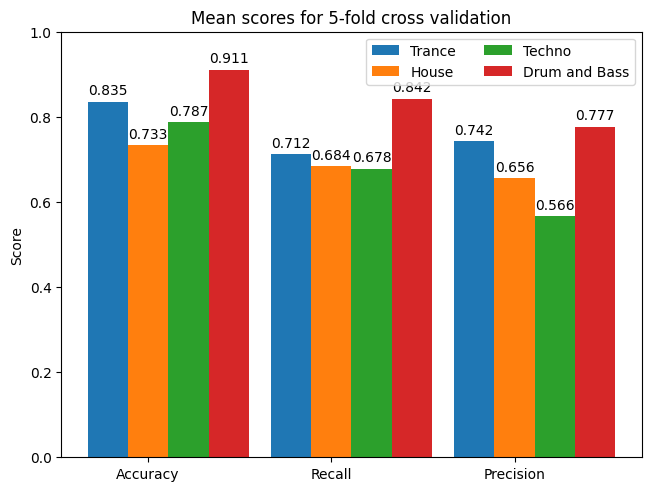

In [10]:
# Plot average scores into a bar plot.
average_validation_results = {k : sum([r[k] for r in validation_results])/5 for k in ['Accuracy', 'Recall', 'Precision']}
plot_scores(average_validation_results, 'Mean scores for 5-fold cross validation')

In [15]:
# Train on full training data set and score on test set.
training_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

mu = torch.mean(dataset.dataset.data, dim=0)
sigma = torch.std(dataset.dataset.data, dim=0)
model = ABModel(X.shape[1], 500, 100, 20, mu=mu, sigma=sigma).to(device="cuda:0")
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
train(50, model, loss_fn, optimizer, training_loader)
test_scores = score(model, test_loader)
print_scores(model, test_loader)
torch.save(model.state_dict(), "/content/drive/MyDrive/"\
                    "may-summer-2024-music-subgenre-classification/"\
                    "Reid_models/model_parameters.pt")

	            Trance     House      Techno     Drum and Bass  
	 Accuracy   0.8630     0.7473     0.7981     0.9192    
	 Recall     0.7604     0.6821     0.6419     0.8387    
	 Precision  0.7466     0.6964     0.6641     0.8377    


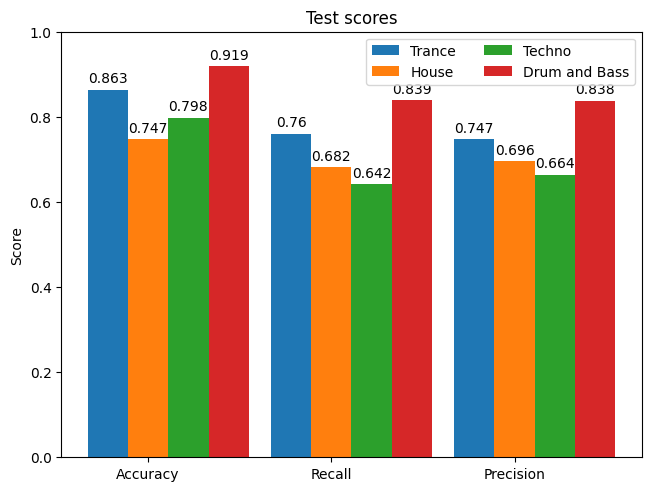

In [16]:
plot_scores(test_scores, 'Test scores')

Other models :

In [17]:
# Train a model on each dataset and save the test set scores to model_scores.
model_scores = []
for i in range(1, 4) :
  training_time = 0

  filename = "/content/drive/MyDrive/"\
                      "may-summer-2024-music-subgenre-classification/"\
                      "music_subgenre_classification/"\
                      "electronic_df_EDAv"+str(i)+".pkl"

  df2 = pd.read_pickle(filename)

  # Drop non-numerical columns.
  df2.drop(['mbdata.id', 'mbdata.title', 'mbdata.artist-name', 'mbdata.artist-id',
        'mbdata.all-tags', 'mbdata.genre'], inplace=True, axis=1)

  # Create pytorch tensors.
  X2 = torch.tensor(df2.iloc[:,:-4].values).float().to(device="cuda:0")
  y2 = torch.tensor(df2.iloc[:,-4:].values).float().to(device="cuda:0")

  # Split data into training and validation sets
  dataset2 = ABDataset(X2, y2)
  train_set2, val_set2 = torch.utils.data.random_split(dataset2, [30000, len(dataset2)-30000])

  # Calculate mean and standard deviation of training set.
  mu2 = torch.mean(train_set2.dataset.data, dim=0)
  sigma2 = torch.std(train_set2.dataset.data, dim=0)

  # Create data loaders.
  training_loader2 = torch.utils.data.DataLoader(train_set2, batch_size=128, shuffle=True)
  validation_loader2 = torch.utils.data.DataLoader(val_set2, batch_size=1, shuffle=False)

  # Loss function will be the binary cross-entropy.
  loss_fn = nn.BCELoss()


  # Train and print scores, training time for each cross-validation.
  n = X2.shape[1]
  model2 = ABModel(n, 500, 100, 20, mu=mu2, sigma=sigma2).to(device="cuda:0")
  optimizer2 = torch.optim.SGD(model2.parameters(), \
                              lr=0.001, momentum=0.9)
  print("Model ", i, ": electronic_df_EDAv"+str(i)+".pkl")
  print("\t", X2.shape[1], " features\n")
  start = time.time()
  train(50, model2, loss_fn, optimizer2, training_loader2)
  end = time.time()
  training_time += end-start
  model_scores.append(score(model2, validation_loader2))
  print_scores(model2, validation_loader2)
  print("\nTraining Time : ", training_time)
  print("\n------------------------------------------------------\n")

Model  1 : electronic_df_EDAv1.pkl
	 603  features

	            Trance     House      Techno     Drum and Bass  
	 Accuracy   0.7991     0.7377     0.8584     0.8943    
	 Recall     0.7466     0.7038     0.7852     0.7989    
	 Precision  0.5070     0.6055     0.7002     0.7385    

Training Time :  28.051312923431396

------------------------------------------------------

Model  2 : electronic_df_EDAv2.pkl
	 476  features

	            Trance     House      Techno     Drum and Bass  
	 Accuracy   0.8011     0.7508     0.8612     0.8909    
	 Recall     0.7113     0.7076     0.8067     0.8108    
	 Precision  0.5465     0.6413     0.6781     0.7137    

Training Time :  28.32291030883789

------------------------------------------------------

Model  3 : electronic_df_EDAv3.pkl
	 379  features

	            Trance     House      Techno     Drum and Bass  
	 Accuracy   0.7957     0.7301     0.8496     0.8843    
	 Recall     0.7467     0.6923     0.7928     0.7740    
	 Precision  0.

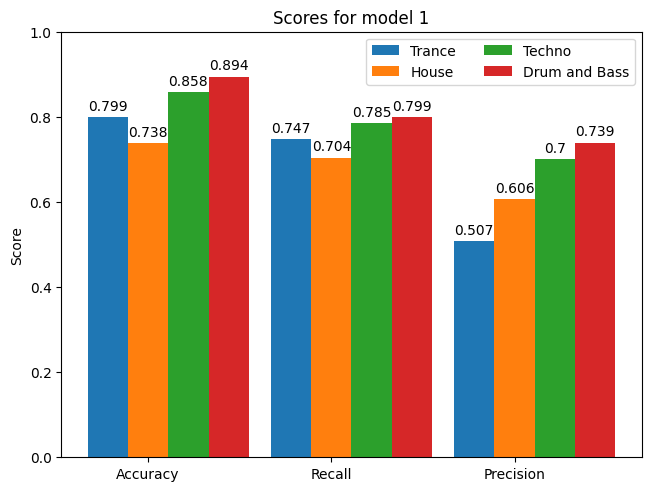

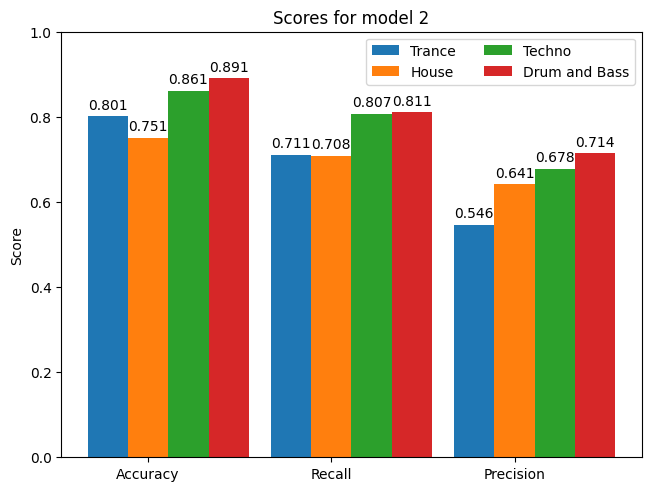

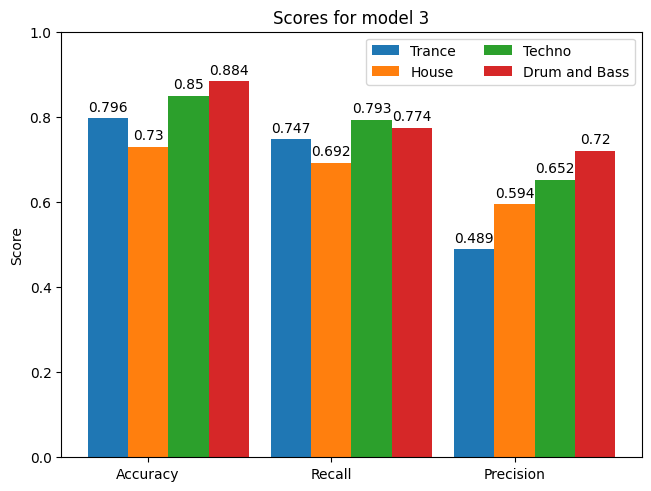

In [18]:
for i, s in enumerate(model_scores) :
  plot_scores(s, "Scores for model {}".format(i+1))